# Tweet Emotion Recognition:NLP using Tensorflow

# 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# 2. Importing Data

In [2]:
#dataset preparation
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [3]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [4]:
training_data=dataset['train']
validation_data=dataset['validation']
test_data=dataset['test']

In [5]:
training_data[0]

{'label': 'sadness', 'text': 'i didnt feel humiliated'}

In [6]:
validation_data[0]

{'label': 'sadness',
 'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon'}

In [7]:
test_data[0]

{'label': 'sadness',
 'text': 'im feeling rather rotten so im not very ambitious right now'}

In [8]:
def get_tweets(data):
    tweets=[x['text'] for x in data]
    labels=[x['label'] for x in data]
    
    return tweets,labels
    

In [9]:
tweets,labels=get_tweets(training_data)

In [10]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

# 3. Tokenizer

In [11]:
#Tokenization
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


# 4. Padding and truncating sequence

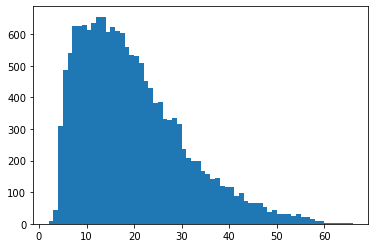

In [13]:
#Padding truncating sequences
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [14]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [15]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [16]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

# 5. Preparing Labels

In [17]:
#preparing labels
classes=set(labels)
print(classes)

{'fear', 'sadness', 'anger', 'surprise', 'love', 'joy'}


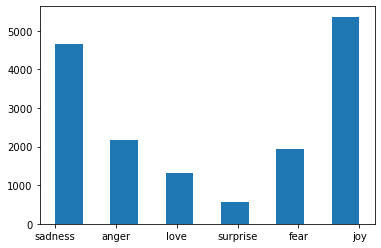

In [18]:
plt.hist(labels,bins=11)
plt.show()

In [19]:
classes_to_index=dict((c,i) for i,c in enumerate(classes))
print(classes_to_index)
index_to_classes=dict((v,k)for k,v in classes_to_index.items())
print(index_to_classes)

{'fear': 0, 'sadness': 1, 'anger': 2, 'surprise': 3, 'love': 4, 'joy': 5}
{0: 'fear', 1: 'sadness', 2: 'anger', 3: 'surprise', 4: 'love', 5: 'joy'}


In [20]:
names_to_ids=lambda labels:np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
train_labels

array([1, 1, 2, ..., 5, 2, 1])

# 6. Creating the model

In [21]:
#creation of model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# 7. Training the model

In [22]:
#training the model
val_tweets, val_labels = get_tweets(validation_data)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [23]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [24]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 12s 18ms/step - loss: 1.2880 - accuracy: 0.5067 - val_loss: 0.8388 - val_accuracy: 0.7170
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5568 - accuracy: 0.8055 - val_loss: 0.5523 - val_accuracy: 0.8160
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3389 - accuracy: 0.8841 - val_loss: 0.4857 - val_accuracy: 0.8355
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2369 - accuracy: 0.9150 - val_loss: 0.4382 - val_accuracy: 0.8510
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1667 - accuracy: 0.9442 - val_loss: 0.3945 - val_accuracy: 0.8715
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1207 - accuracy: 0.9616 - val_loss: 0.3998 - val_accuracy: 0.8885
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.0925 - accuracy: 0.9703 - val_loss: 0.3956 - val_accuracy: 0.883

# 8. History of model

In [25]:
def show_history(h):
    epochs_trained=len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1,2,1)
    plt.plot(range(0,epochs_trained),h.history.get('accuracy'),label='Training')
    plt.plot(range(0,epochs_trained),h.history.get('val_accuracy'),label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

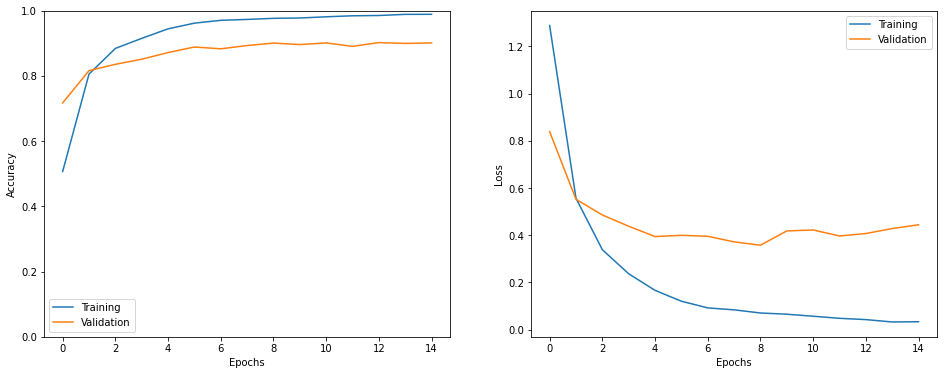

In [26]:
show_history(h)

# 9.Testing the model

In [27]:
#testing the model
test_tweets, test_labels = get_tweets(test_data)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [28]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 5ms/step - loss: 0.4724 - accuracy: 0.8855


In [43]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Actual Emotion:', index_to_classes[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i was stressed about my job search and apartment hunting and i was just feeling overwhelmed with everything that was going on
Actual Emotion: fear
Predicted Emotion: fear


In [30]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

((2000,), (2000,))

In [42]:
tf.__version__

'2.5.0'